# Исследование оттока и удержания клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию удержания оттоковых клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
    
Цель: провести анализ и подготовить план действий по удержанию клиентов.

Задачи:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  1. выделить целевые группы клиентов;
  2. предложить меры по снижению оттока;
  3. определить другие особенности взаимодействия с клиентами.

In [1]:
#загрузка библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

!pip install phik==0.10.0
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

!pip install kaleido
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

## Загрузка и обзор данных

In [2]:
#загрузка данных

df = pd.read_csv('All projects Practicum/gym_churn.csv', sep=',')
df.head(15)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [3]:
#посмотрим размер таблицы

df.shape

(4000, 14)

В данных 4000 строк и 14 колонок.

In [4]:
#выведем информацию по типам данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Столбцы `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits`, `churn` содержат значения 0 / 1, поэтому логичнее было бы перевести их в тип данных `boolean`, но ML алгоритмы не умеют работать с таким типом данных, поэтому оставим их в целочисленном типе данных.

Столбец `month_to_end_contract` можно привести к `int`, поскольку в нем только целые числа. Также приведем названия столбцов к нижнему регистру.

In [5]:
#меняем тип данных 

df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int')

In [6]:
#приводим названия столбцов к нижнему регистру

df.columns = df.columns.str.lower()
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [7]:
#определим, в каких столбцах есть пропуски

df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропусков нет.

Проверим данные на наличие явных дубликатов.

In [8]:
df.duplicated().sum()

0

Дубликатов нет.

**Вывод**
- В данных 4000 записей, пропусков и дубликатов нет.
- Заголовки приведены к нижнему регистру. Столбцы приведены к нужному типу данных.

## EDA (Исследовательский анализ данных)

### Изучение датасета (средние значения и стандартные отклонения)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- В выборке приблизительно поровну мужчин и женщин;
- Большинство клиентов (85%) проживают или работают в районе, где находится фитнес-центр;
- Примерно половина клиентов являются сотрудниками компаний-партнёров клуба, т.е. могли оформить абонемент со скидкой;
- Около 31% клиентов при оплате первого абонемента воспользовались акицей "приведи друга";
- Номера телефонов указаны в 90% анкет;
- Средняя длительность действующего абонемента составляет 4-5 месяцев, при этом в 25% случаев клиенты покупали и более длительные абонементы (от 6 месяцев);
- 41% клиентов посещают групповые занятия;
- Средний возраст клиентов - 29 лет. Минимальный возраст клиентов - 18 лет, а максимальный - 41.
- Средняя суммарная выручка от дополнительных услуг (кафе, спорттовары) фитнес-центра ~ 147 ден.ед.
- Средний срок окончания действия текущего абонемента - 4 месяца. Стандартное отклонение в 4 месяца свидетельствует о большом разбросе значений. Больше половины клиентов имеют всего 1 месяц занятий;
- Среднее время жизни клиента - 4 месяца;
- В среднем клиенты посещают клуб дважды за неделю, однако есть и те, кто занимаются 6 раз в неделю;
- Средняя частота посещений за предыдыщий месяц - также дважды в неделю;
- В среднем уходят 26% клиентов.

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [10]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Выявим интересные наблюдения по средним значениям двух выборок:
- Клиенты, проживающие в районе фитнес центра чаще остаются, чем уходят в отток (среди оставшихся 87% местных, среди ушедших 77% местных);
- Клиенты, работающие в компаниях-партнерах клуба и получающие скидки от фитнес-центра, чаще остаются (53% против 36% тех, кто ушел в отток);
- Клиенты, получившие скидку по акции "приведи друга", более лояльнее (35% против 18%, ушедших в отток);
- Неоттоковые клиенты в среднем чаще посещают групповые занятия: 46% против 27% у оттоковых клиентов;
- Неоттоковые клиенты имеют средний возраст - 30 лет, тогда как оттоковые клиенты - 27 лет;
- Средняя частота посещений за весь период у оттоковых клиентов, попавших в отток, ниже, чем у лояльных (1.47 против 2 раз в неделю);
- Средняя частота посещений за последний месяц у оттоковыъ клиентов в 2 раза ниже, чем у лояльных - 1 против 2 раз в неделю.

### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

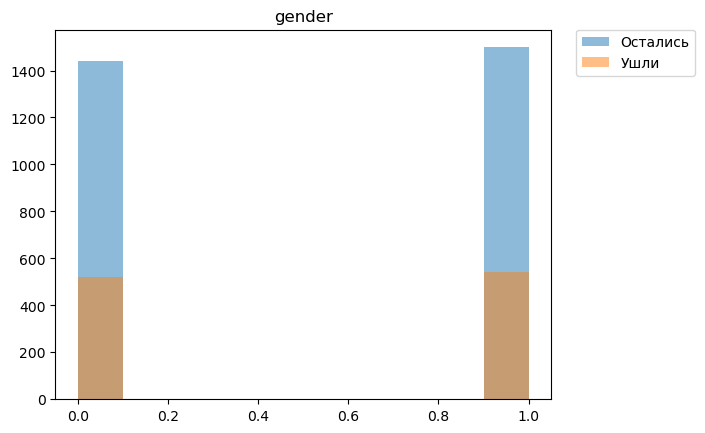

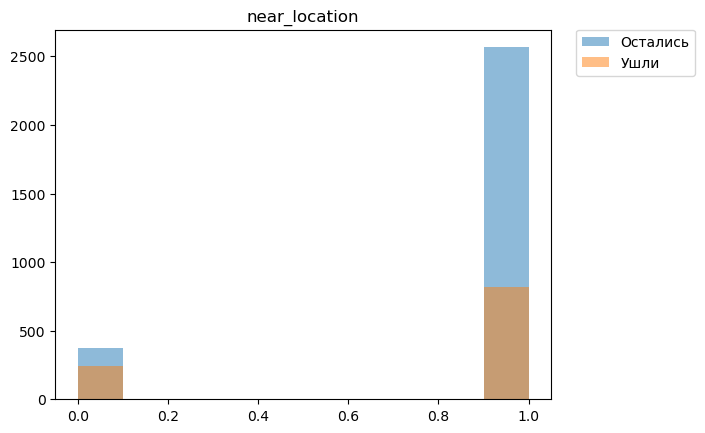

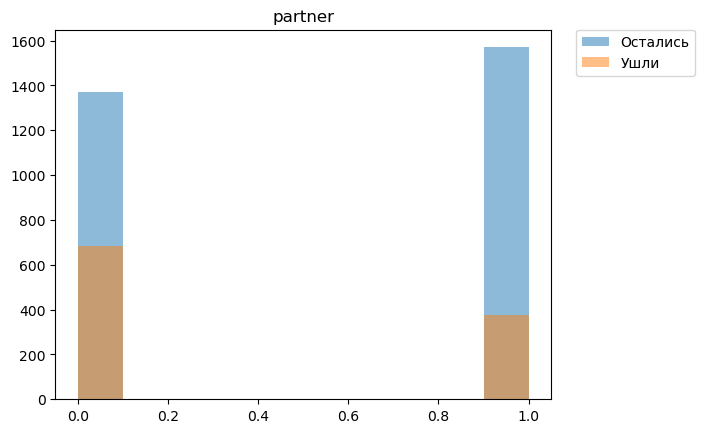

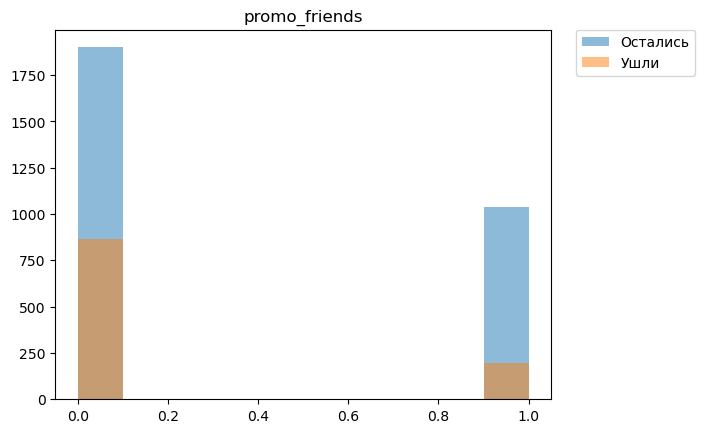

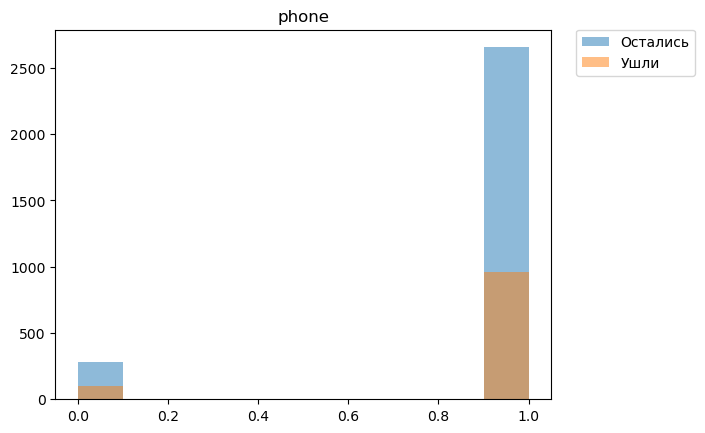

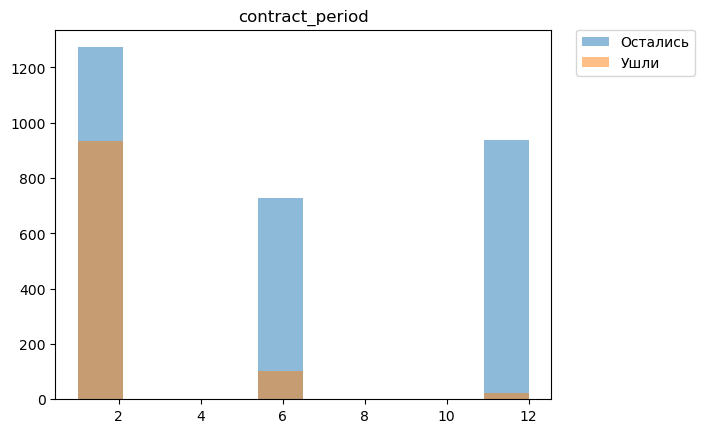

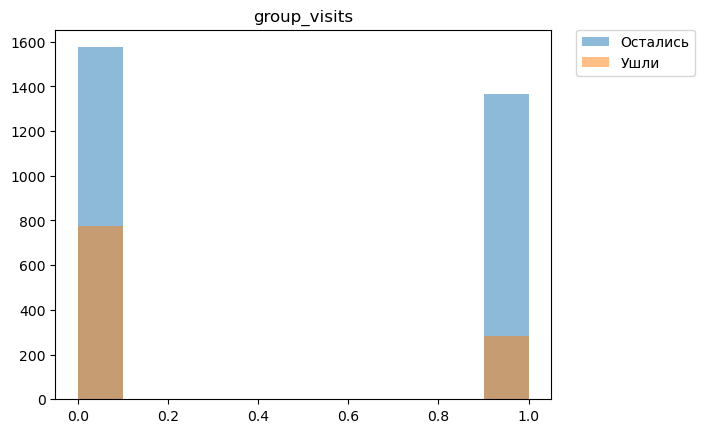

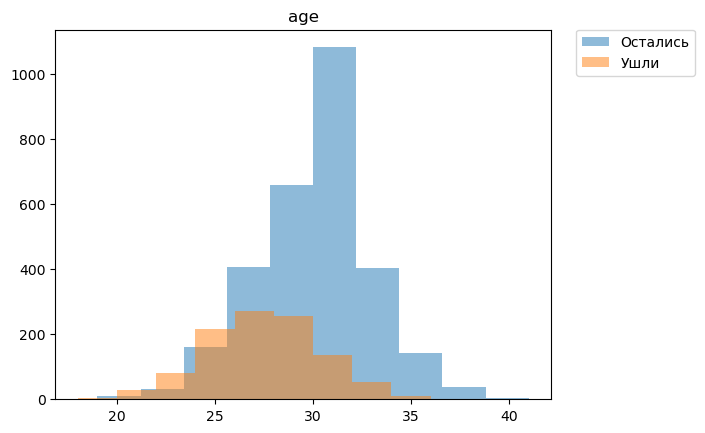

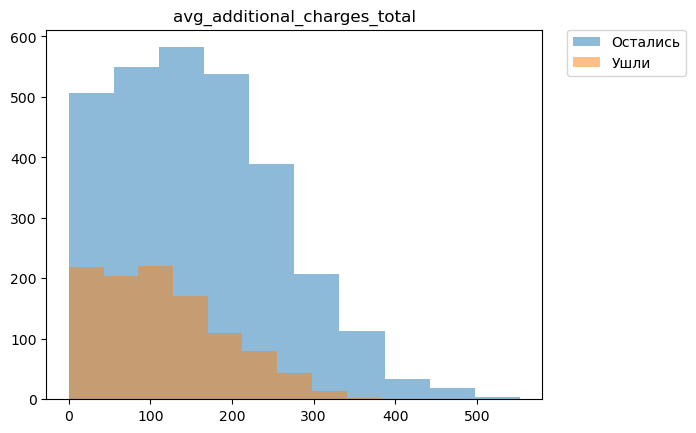

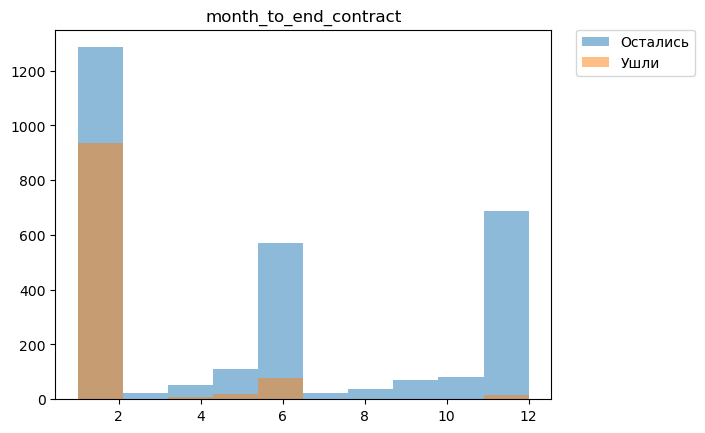

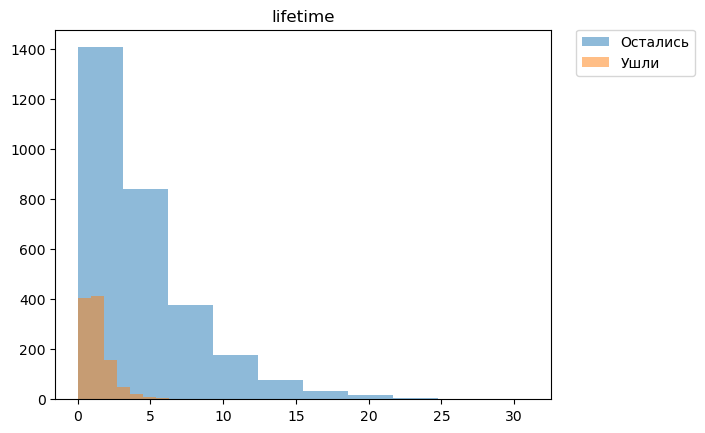

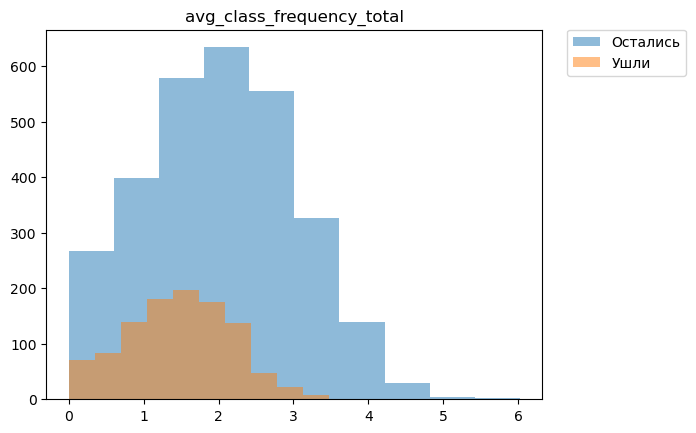

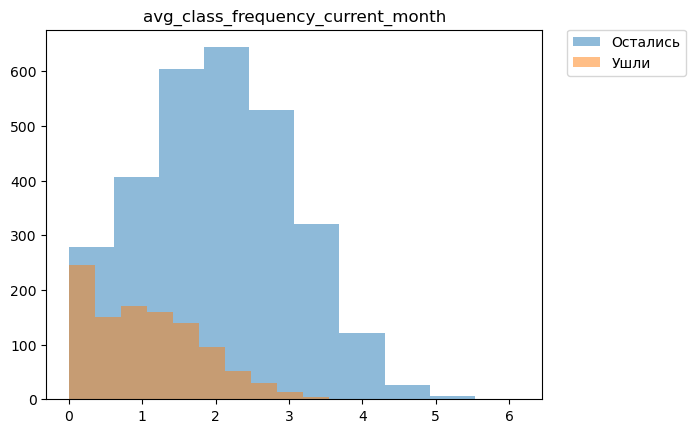

In [11]:
churn_yes = df[df['churn'] == 1]
churn_no = df[df['churn'] == 0]

for column in df.columns:
    if column == 'churn':
        continue
    plt.hist(churn_no[column], alpha=0.5, label='Остались')
    plt.hist(churn_yes[column], alpha=0.5, label='Ушли')
    plt.legend(bbox_to_anchor=( 1.05, 1 ), loc='upper left', borderaxespad= 0)
    plt.title(column)
    plt.show()

Исходя из графиков, меньший отток демонстрируют:

- клиенты, проживающие в районе фитнес центра;
- сотрудники компаний партнеров;
- клиенты, пришедшие в рамках акции "приведи друга";
- клиенты с длительным сроком действия абонемента (от 6-12 месяцев);
- клиенты в возрасте от 28-30 лет.

Чаще всего отток демонстрируют:

- клиенты со сроком действия абонемента менее 6 месяцев, в особенности краткосрочных 1 месяц;
- клиенты в возрасте до 28 лет;
- клиенты, не живущие рядом с фитнес-центром;
- клиенты, у которых остается малый срок до конца срока действия абонемента (месяц до окончания);
- клиенту, у которых длительность текущего действующего абонемента - около 1 месяца;
- клиенты посещающие занятия реже двух раз в неделю.


### Матрица корреляций

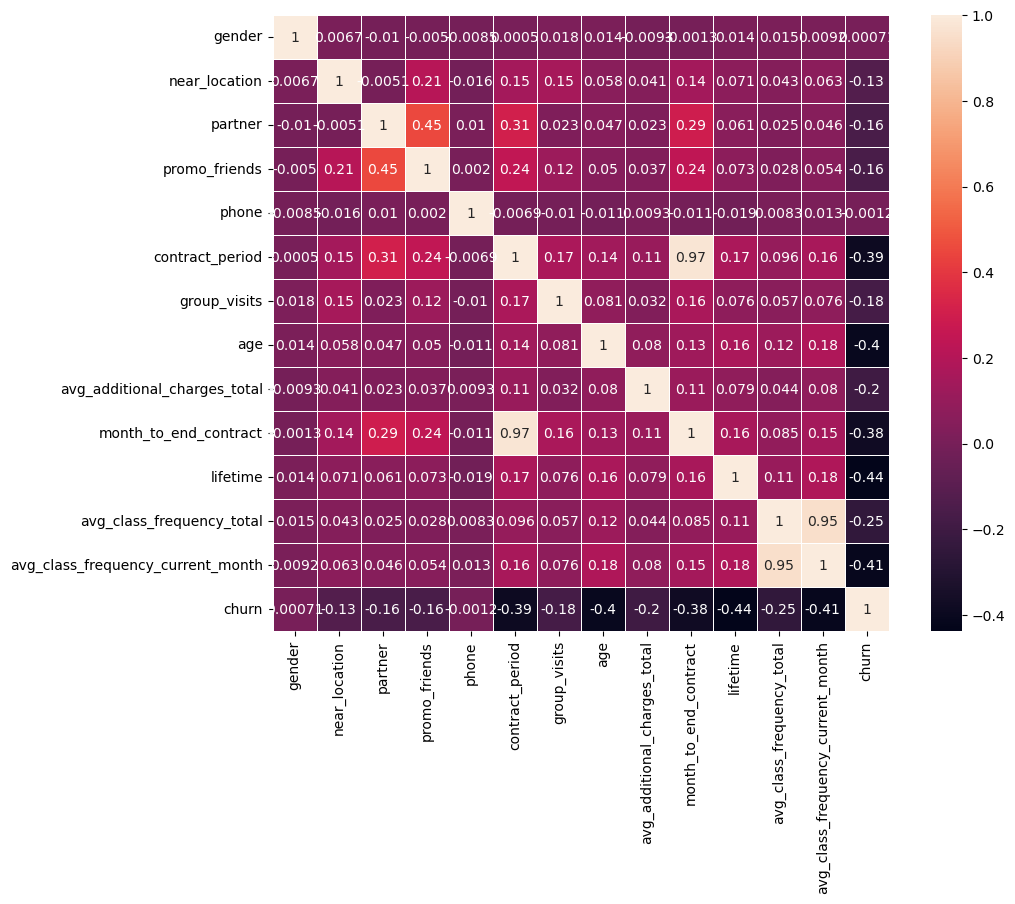

In [12]:
#построим и отрисуем матрицу корреляций
cm = df.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(11, 8))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True, linewidths=.4) 
plt.show()

Признаков, значимо влияющих на отток, на карте не наблюдается.

- Больше остальных с целевой переменной коррелирует lifetime клиента (чем значение больше, тем меньше вероятность оттока).
- Далее по значимости следуют средняя частоста посещений клуба за последний месяц, возраст, длительность действующего абонемента и количество месяцев до истечения абонемента.
- Наблюдается почти линейная зависимость между сроком абонемента (contract_period) и количеством месяцев до конца абонемента (month_to_end_contract),а также между средней частотой посещений за весь период (avg_class_frequency_total) и средней частотой посещений за последний месяц (avg_class_frequency_current_month).

In [13]:
cols_to_keep = ["gender", "near_location", "partner", "promo_friends",
                "group_visits", "churn"]
               
df_corr = df[cols_to_keep]
df_corr.head()

,gender,near_location,partner,promo_friends,group_visits,churn
0,1,1,1,1,1,0
1,0,1,0,0,1,0
2,0,1,1,0,0,0
3,0,1,1,1,1,0
4,1,1,1,1,0,0


In [14]:
phik_overview = df_corr.phik_matrix()

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'group_visits', 'churn']


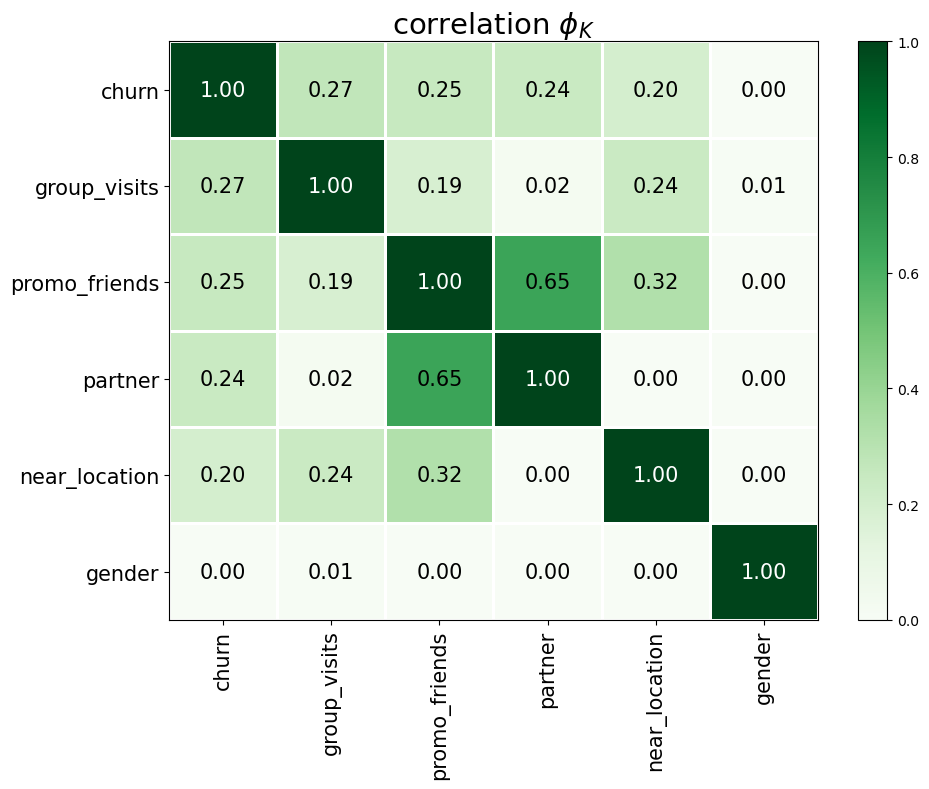

In [15]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

С целевой переменной больше всех коррелируют групповые посещения, акция "приведи друга" и партнерство с компанией. С гендером корреляция отсутсвует.

## Модель прогнозирования оттока клиентов

### Разбиение данных на обучающую и валидационную выборки.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [16]:
#разделим данные на признаки (матрица X) и целевую переменную (y)

X = df.drop('churn', axis = 1)
y = df['churn']

In [17]:
#разделяем данные на валиадационную выборку и обучающую

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Модели "Логистическая регрессия" и "Случайный лес".

Обучим модель на train-выборке двумя способами:
- логистической регрессией
- случайным лесом

In [18]:
#логистическая регрессия
 
lr_model = LogisticRegression(random_state=0,solver='liblinear')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

In [19]:
#случайный лес

rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

### Оценка метрик классификации.

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. 

In [20]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82
	F1: 0.83
	ROC_AUC: 0.97


**Выводы**

- Accuracy (Доля правильных ответов) чуть лучше у модели логистической регрессии (0.93). 
- Precision (Точность) также выше у модели логистической регрессии (86% против 84%).
- Recall (Полнота) чуть лучше у модели логистической регрессии (83% против 82%).
- F1-мера лучше у логистической регрессии  (85% против 83%).
- ROC_AUC (Оценка качества модели классификации) одинакова у обоих моделей.

Таким образом, модель логической регрессии показала чуть лучшие результаты.

## Кластеризация клиентов

### Стандартизация данных.

In [21]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Матрица расстояний и дендрограмма.

In [22]:
linked = linkage(X_sc, method = 'ward') 

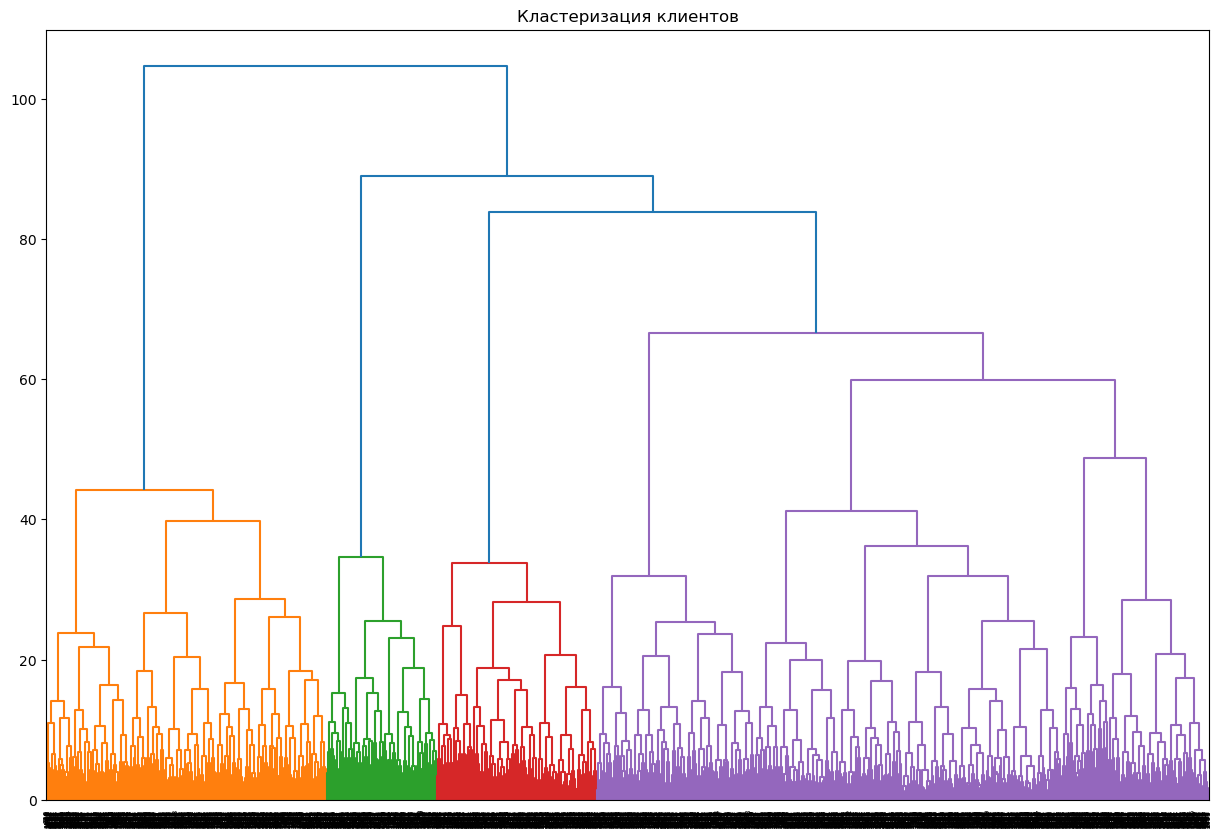

In [23]:
#визуализируем дендрограмму

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Данные целесообразно было бы разделить на 4 кластера. Однако согласно условию задачи, установим число кластеров равным 5 для дальнейшего исследования.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

### Кластеризации по алгоритму K-Means и прогнозирование кластеров клиентов.

In [24]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,3


### Средние значения признаков для кластеров

In [25]:
# выводим статистику по средним значениям наших признаков по кластеру

df.groupby(['cluster_km']).mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


In [26]:
#сколько клиентов попало в каждый кластер

df['cluster_km'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster_km, dtype: int64

Размерность кластеров от 385 до 1262.

Исходя из статистики по средним значениям признаков в кластерах:

- Самые лояльные клиенты попали в кластеры 0 и 4 (уровень оттока от 3 до 7 %), а наименее лояльные клиенты находятся в кластерах 2 и 3 (где уровень оттока составляет 44% и 51% соответственно).
- В группы лояльных клиентов (0 и 4) попали люди, проживающие рядом с фитнес центром, тратящие в среднем больше остальных на доп. услуги и примерно половина из них посещает групповые занятия. Средний возраст клиентов - 30 лет.
- В кластере с отточными клиентами (2 и 3) более молодые клиенты (28 лет). Они имеют краткосрочные абонементы и реже остальных посещают зал.

### Распределение признаков по кластерам

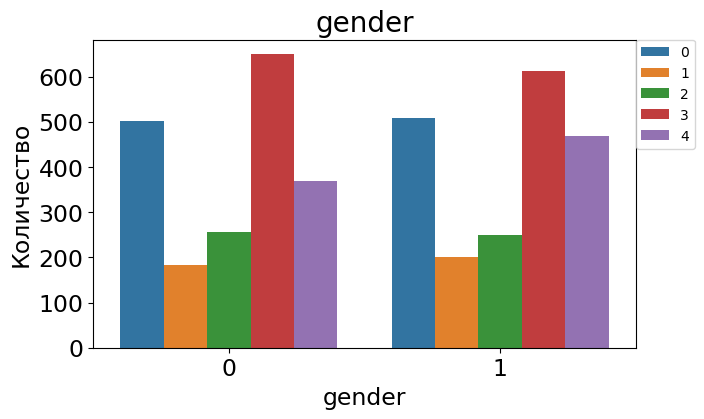

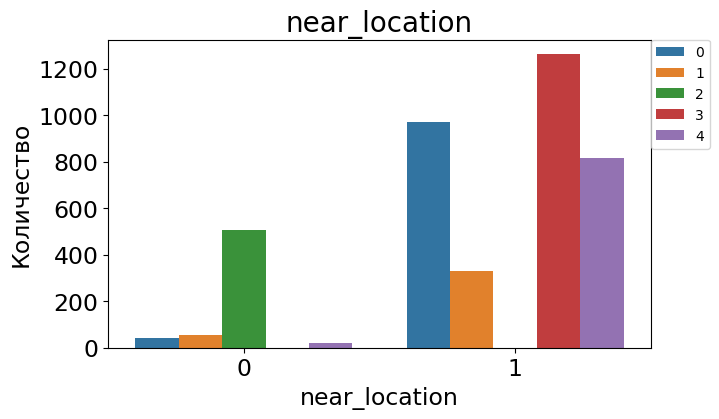

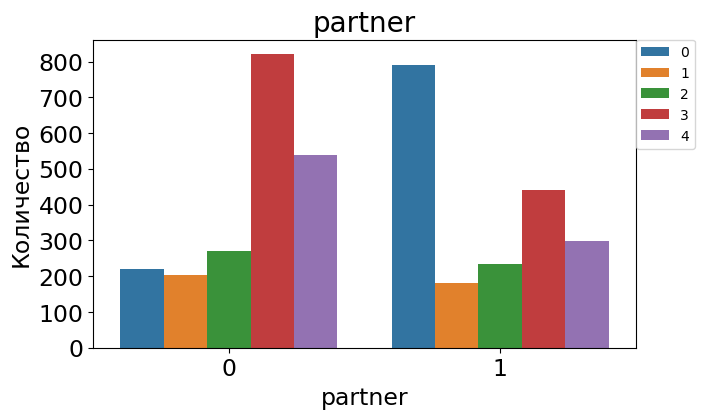

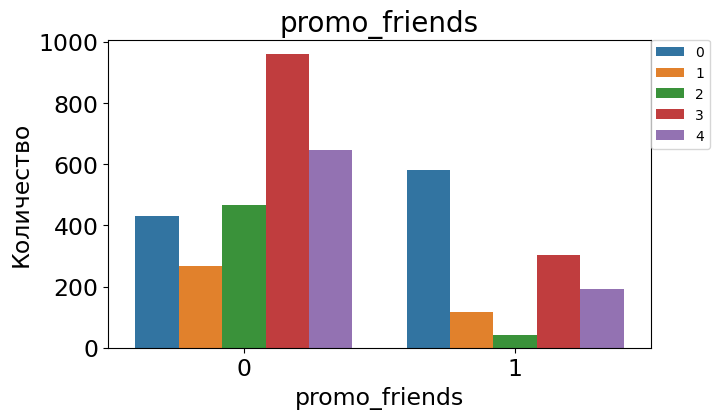

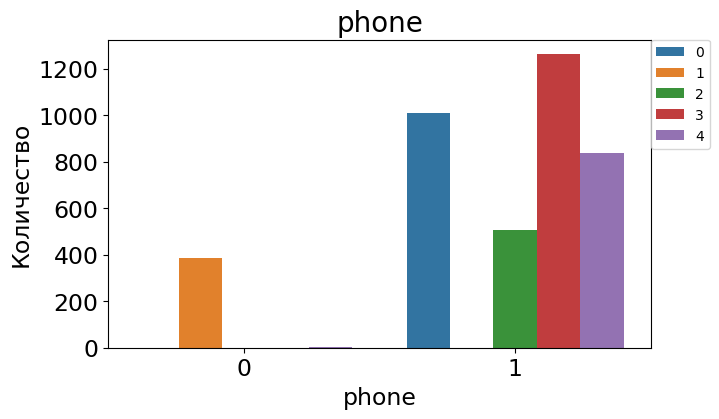

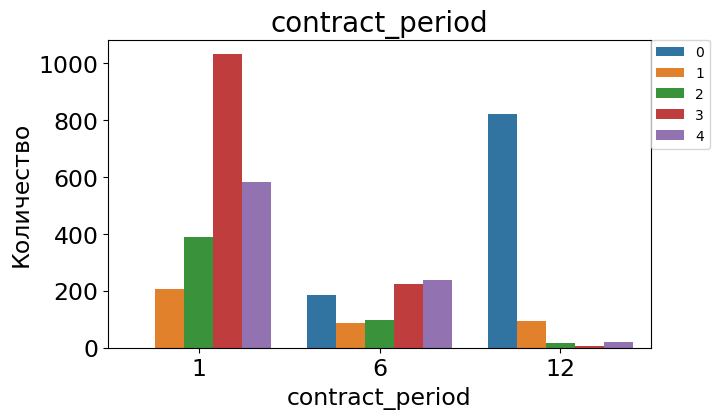

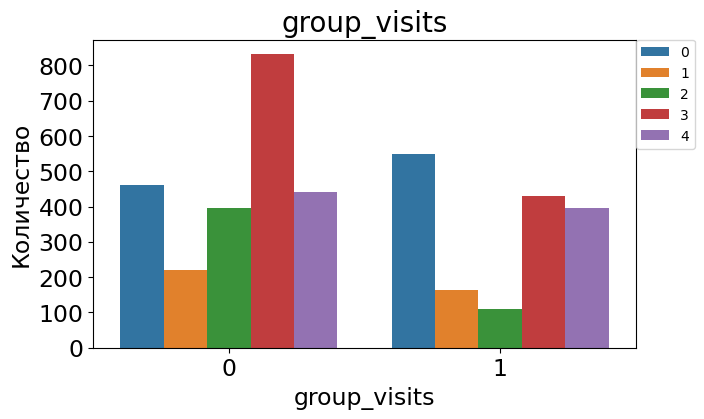

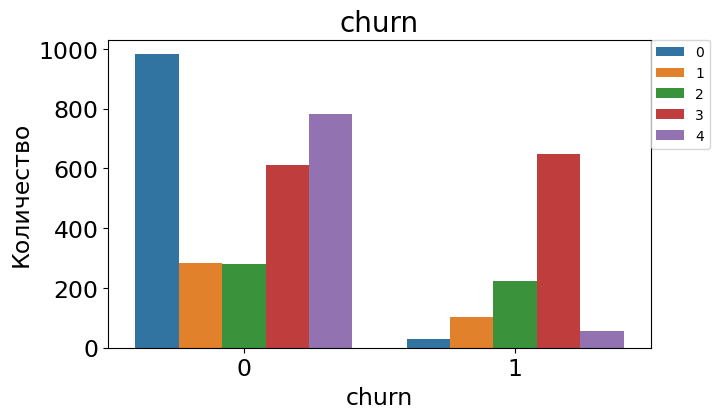

In [27]:
for column in df.columns:
    if len(df[column].unique()) <= 3:
        plt.figure(figsize=(7, 4))
        sns.countplot(x = column, data=df, hue='cluster_km')
        plt.title(column, fontsize=20)
        plt.legend(fontsize=17)
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=17)
        plt.xlabel(column, fontsize=17)
        plt.ylabel('Количество', fontsize=17)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad= 0)
        plt.show

**Вывод**

По итогам построения графиков распределения выявлены следующие характерные черты для кластеров:

**Кластер 0** - это в основном клиенты:
- проживающие рядом с фитнес - центром;
- являющиеся сотрудниками компаний-партнеров;
- имеющие длительные абонементы в фитнес-зал;
- посещающие групповые занятия;
- имеющие возраст 30 лет;
- **имеющие самую низкую долю оттока, то есть являются наиболее лояльными клиентами**.


**Кластер 1** - это в основном клиенты:
- проживающие рядом с фитнес - центром;
- большая доля пришла не по рекомендации друзей;
- в равных долях являются как сотрудниками компаний-партнеров, так и не являются таковыми;
- не предоставившие номер телефона;
- срок абонемента чаще всего на 1 месяц;
- реже посещающие групповые занятия;
- средний возраст около 29 лет;
- имеющие высокую долю оттока.

**Кластер 2** - это в основном клиенты:
- проживающие далеко от фитнес - центра
- большинство пришло не по рекомендации друзей;
- имеющие короткие абонементы (1 месяц);
- большинство из них не посещают групповые занятия;
- имеющие средний возраст - 28 лет;
- имеющие высокую долю оттока;

**Кластер 3** - это в основном клиенты:
- прожвивающие рядом с фитнес-центром;
- не являются сотрудниками компаний-партнеров;
- не являются участниками акции "приведи друга";
- не посещающие групповые занятия;
- имеющие краткосрочные абонементы (1 месяц);
- средний возраст - 27-28 лет;
- **имеющие самую высокую долю оттока в группе**.

**Кластер 4** - это в основном клиенты:
- проживающие рядом с фитнес-центром;
- являющиеся сотрудниками компаний-партнеров;
- большинство пришли по рекомендации друзей;
- имеют средний либо краткосрочный абонемент;
- средний возраст - 30 лет;
- имеют невысокую долю оттока в группе. 

Идеальными клиентами являются клиенты из кластеров №0 и 4, поскольку они имеют меньшую долю оттоков.

Наименнее лояльными клиентами являются клиенты из кластера 3, имеющие самую высокую долю оттока.

### Доли оттока по кластерам

In [28]:
churn_shares = df.groupby('cluster_km').agg({'churn':'mean'}).reset_index().rename(columns={'churn':'churn_rate'})
churn_shares

,cluster_km,churn_rate
0,0,0.027723
1,1,0.267532
2,2,0.443564
3,3,0.514263
4,4,0.068019


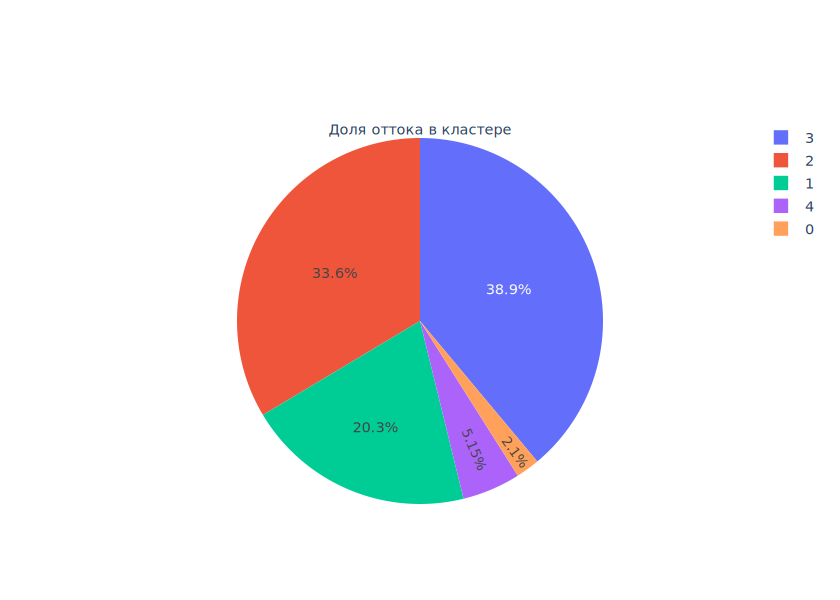

In [29]:
fig = go.Figure(data=[go.Pie(labels=churn_shares.index, values=churn_shares['churn_rate'].values, title='Доля оттока в кластере')]);
fig.show()

**Вывод**

Как и предполагалось, кластеры 0 и 4 имеют наименьшую долю оттока. Кластеры 2 и 3 имеют наибольшую долю оттока.


## Выводы и рекомендации по работе с клиентами

### Общие выводы

В данной работе мы проанализировали данные о клиентах фитнес-центра, чтобы дать рекомендации по удержанию оттоковых клиентов. 

Для прогнозирования оттока клиентов было построено две модели:
- логистическая регрессия;
- случайный лес. 

Основываясь на ключевых метриках оценки моделей `accurancy`, `precision` и `recall` можно сказать, что обе модели хорошо прогнозируют вероятность оттока, но чуть лучше показывает себя - Логистическая регрессия.

Далее мы провели кластеризацию, в результате которой приняли решение разделить клиентов на 5 кластеров. Затем описали получившиеся кластеры по признакам:

**Кластер 0** - это в основном клиенты:
- проживающие рядом с фитнес - центром;
- являющиеся сотрудниками компаний-партнеров;
- имеющие длительные абонементы в фитнес-зал;
- посещающие групповые занятия;
- имеющие возраст 30 лет;
- **имеющие самую низкую долю оттока, то есть являются наиболее лояльными клиентами**.


**Кластер 1** - это в основном клиенты:
- проживающие рядом с фитнес - центром;
- большая доля пришла не по рекомендации друзей;
- в равных долях являются как сотрудниками компаний-партнеров, так и не являются таковыми;
- не предоставившие номер телефона;
- срок абонемента чаще всего на 1 месяц;
- реже посещающие групповые занятия;
- средний возраст около 29 лет;
- имеющие высокую долю оттока.

**Кластер 2** - это в основном клиенты:
- проживающие далеко от фитнес - центра
- большинство пришло не по рекомендации друзей;
- имеющие короткие абонементы (1 месяц);
- большинство из них не посещают групповые занятия;
- имеющие средний возраст - 28 лет;
- имеющие высокую долю оттока;

**Кластер 3** - это в основном клиенты:
- прожвивающие рядом с фитнес-центром;
- не являются сотрудниками компаний-партнеров;
- не являются участниками акции "приведи друга";
- не посещающие групповые занятия;
- имеющие краткосрочные абонементы (1 месяц);
- средний возраст - 27-28 лет;
- **имеющие самую высокую долю оттока в группе**.

**Кластер 4** - это в основном клиенты:
- проживающие рядом с фитнес-центром;
- являющиеся сотрудниками компаний-партнеров;
- большинство пришли по рекомендации друзей;
- имеют средний либо краткосрочный абонемент;
- средний возраст - 30 лет;
- имеют невысокую долю оттока в группе. 

Лояльными (надежными) клиентами являются клиенты из кластеров №0 и 4. Ненадежными клиентами являются кластеры 1, 2, 3.


### Рекомендации по стратегии взаимодействия с клиентами и их удержания.

Сформируем рекомендации отделу маркетинга.

**Рекомендации по удержанию оттоковых клиентов**
- Поскольку оттоковые клиенты в основном берут краткосрочные абонементы (на 1 месяц), то можно предложить бесплатное составление программы тренировок фитнес-тренером и одно бесплатное занятие с тренером, чтобы клиенты наметили себе план и более дисциплинированно посещали тренировки. 
- Разнообразить программу групповых тренировок и активно предлагать такие тренировки оттоковым клиентам, поскольку находясь в группе, знакомясь и общаясь между собой, люди формируют коммьюнити и поддерживают друг друга, чтобы не бросать занятия. 

**Рекомендации по взаимодействию и привлечению лояльных клиентов**
- Расширить рекламу в близлежащих районах, поскольку рядом живущие люди являются самыми лояльными клиентами.
- Расширять партнерскую программу и сотрудничать с новыми организациями для привлечения их сотрудников в фитнес-центр, поскольку клиенты от компаний-партнеров также являются наиболее лояльными клиентами. 
- Акция "приведи друга" также способствует привлечению лояльных клиентов, поэтому можно ее продлить и расширить систему бонусов. 
- Мотивировать клиентов на регулярные посещения зала (2-3 раза в неделю), например, создав приложение, которое напоминает о занятиях, присылает push-уведомления и информирует о различных активностях. Клиенты, посещающие зал 2-3 раза в неделю, менее склонны к оттоку. 
- Реклама и продвижение должны быть направлены на людей в возрасте 30 лет, отражать их ценности и затрагивать их потребительские боли. Важно выяснить, для чего в этом возрасте люди начинают заниматься спортом, какие проблемы хотят решить и выстроить рекламу на этих ценностях.